In [1]:
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
from unityagents import UnityEnvironment

from utils import create_next_id_folder
from ddpg_agent_multi import SharedAgent

In [2]:
# Create simulation environment
env = UnityEnvironment(file_name='Reacher_Windows_x86_64_20/Reacher.exe')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [4]:
states.shape

(20, 33)

In [5]:
states.shape[1]

33

In [6]:
len(env_info.rewards)

20

In [7]:
# Initialize Feed-forward DNNs for Actor and Critic models. 
agent = SharedAgent(state_size=state_size, action_size=action_size, random_seed=0)

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
steps = 0
while True:
    steps += 1 
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.21049999529495836


In [8]:
scores

array([0.        , 0.        , 0.31999999, 0.        , 0.36999999,
       0.49999999, 0.        , 0.        , 0.48999999, 0.        ,
       0.22      , 0.        , 0.67999998, 0.        , 0.        ,
       0.        , 0.        , 0.35999999, 0.73999998, 0.52999999])

In [9]:
scores / steps

array([0.        , 0.        , 0.00031968, 0.        , 0.00036963,
       0.0004995 , 0.        , 0.        , 0.00048951, 0.        ,
       0.00021978, 0.        , 0.00067932, 0.        , 0.        ,
       0.        , 0.        , 0.00035964, 0.00073926, 0.00052947])

In [10]:
def ddpg(env, 
        state_size, 
        action_size, 
        random_seed,
        num_agents,
        n_episodes=2000, 
        max_t=1000, 
        actor_model_save_path='actor.pth',
        critic_model_save_path='critic.pth',
        BUFFER_SIZE = int(1e4),  # replay buffer size
        BATCH_SIZE = 128,        # minibatch size
        GAMMA = 0.99,            # discount factor
        TAU = 1e-3,              # for soft update of target parameters
        LR_ACTOR = 1e-4,         # learning rate of the actor 
        LR_CRITIC = 1e-3,        # learning rate of the critic
        WEIGHT_DECAY = 0,        # L2 weight decay
        learn_every=20, 
        learn_iterations=10,
        ):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores_agents = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    agent = SharedAgent(state_size=state_size, action_size=action_size,
                    random_seed=random_seed,
                    BUFFER_SIZE=BUFFER_SIZE,                  
                    BATCH_SIZE=BATCH_SIZE,
                    GAMMA=GAMMA,
                    TAU=TAU,
                    LR_ACTOR=LR_ACTOR,
                    LR_CRITIC=LR_CRITIC,
                    WEIGHT_DECAY=WEIGHT_DECAY,
                  )

    for i_episode in range(1, n_episodes+1):

        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations                  # get the current state
        scores = np.zeros(num_agents)
        t_to_learn = 0
        for t in range(max_t):
            actions = [agent.act(state) for state in states]

            # actions = agent.act(states)                        # select an action (for each agent)
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            scores += env_info.rewards

            # Step all experiences
            for i in range(num_agents):
                agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i])
            # agent.step(states, actions, rewards, next_states, dones)
            t_to_learn += 1

            if t_to_learn >= learn_every:
                # Learn 20 times
                agent.learn_multiple(num_updates=learn_iterations)
                t_to_learn = 0

            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break

        scores_window.append(scores)                      # save most recent score
        scores_agents.append(scores)                      # save most recent score
        
        column_means_np = np.array(scores_window).mean(axis=0)

        column_means_list = list(column_means_np)

        # Calculate the mean of these column means
        mean_of_column_means_np = column_means_np.mean()

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_of_column_means_np), column_means_list, end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_of_column_means_np), column_means_list)

    torch.save(agent.actor_local.state_dict(), actor_model_save_path)
    torch.save(agent.critic_local.state_dict(), critic_model_save_path)
    return scores_agents

In [11]:
import os
import json
random_seed = 0

base_path = 'ddpg_trials'
combinations = [{
    #     "n_episodes": 200,
    #     "max_t": 1000,
    #     "BUFFER_SIZE": int(1e4),
    #     "BATCH_SIZE": 128,
    #     "GAMMA": 0.99,
    #     "TAU": 1e-3,
    #     "LR_ACTOR": 1e-4,
    #     "LR_CRITIC": 1e-3,
    #     "WEIGHT_DECAY": 0,
    #     "learn_every": 20,
    #     "learn_iterations": 10,
    # },
    # {
    #     "n_episodes": 200,
    #     "max_t": 1000,
    #     "BUFFER_SIZE": int(1e4),
    #     "BATCH_SIZE": 128,
    #     "GAMMA": 0.99,
    #     "TAU": 1e-3,
    #     "LR_ACTOR": 1e-3, # Changed
    #     "LR_CRITIC": 1e-3,
    #     "WEIGHT_DECAY": 0,
    #     "learn_every": 20,
    #     "learn_iterations": 10,
    # },
    #     "n_episodes": 200,
    #     "max_t": 1000,
    #     "BUFFER_SIZE": int(1e10), # Changed 100000
    #     "BATCH_SIZE": 256, # Changed
    #     "GAMMA": 0.95, # Changed
    #     "TAU": 1e-3, # Changed
    #     "LR_ACTOR": 5e-5, # Changed
    #     "LR_CRITIC": 5e-4,
    #     "WEIGHT_DECAY": 0.01,
    #     "learn_every": 20,
    #     "learn_iterations": 10,
    # },
    # {
        "n_episodes": 200,
        "max_t": 1000,
        "BUFFER_SIZE": int(1e4),
        "BATCH_SIZE": 128,
        "GAMMA": 0.99,
        "TAU": 1e-3,
        "LR_ACTOR": 1e-4,
        "LR_CRITIC": 1e-3,
        "WEIGHT_DECAY": 0,
        "learn_every": 5,
        "learn_iterations": 5,
    },
 ]

for properties in combinations:
    new_path = create_next_id_folder(base_path)
    scores = ddpg(env, 
        state_size, 
        action_size, 
        random_seed,
        num_agents=num_agents,
        n_episodes=properties["n_episodes"],
        max_t=properties["max_t"],
        actor_model_save_path=os.path.join(new_path, 'actor.pth'),
        critic_model_save_path=os.path.join(new_path, 'critic.pth'),
        BUFFER_SIZE=properties["BUFFER_SIZE"],
        BATCH_SIZE=properties["BATCH_SIZE"],
        GAMMA=properties["GAMMA"],
        TAU=properties["TAU"],
        LR_ACTOR=properties["LR_ACTOR"],
        LR_CRITIC=properties["LR_CRITIC"],
        WEIGHT_DECAY=properties["WEIGHT_DECAY"],
        learn_every=properties["learn_every"],
        learn_iterations=properties["learn_iterations"],
        )
    
    with open(os.path.join(new_path, 'parameters.json'), 'w') as json_file:
        json.dump(properties, json_file,  indent=4)

    list_of_python_lists = []
    for arr in scores:
        list_of_python_lists.append(arr.tolist())

    with open(os.path.join(new_path, 'scores.json'), 'w') as f:
        json.dump(list_of_python_lists, f, indent=4) # indent makes it human-readable

    all_scores = np.array(list_of_python_lists)
    all_scores = all_scores.T

Successfully created directory: 'ddpg_trials\9'
Episode 100	Average Score: 2.28 [2.293199948742986, 2.251299949679524, 2.2347999500483273, 2.3793999468162657, 2.3419999476522206, 2.337299947757274, 2.3012999485619368, 2.2790999490581454, 2.308399948403239, 2.2376999499835075, 2.275099949147552, 2.1870999511145057, 2.3339999478310345, 2.1910999510250986, 2.3528999474085865, 2.5635999426990748, 2.0602999539487064, 2.3466999475471675, 2.2528999496437607, 2.1100999528355895]]]]2]21]96004]881]6796]32]
Episode 200	Average Score: 3.78 [3.7126999170146884, 3.658299918230623, 3.7278999166749416, 3.7768999155797065, 3.9548999116010966, 3.4954999218694867, 3.756399916037917, 3.789799915291369, 3.712399917021394, 3.758099915999919, 3.8611999136954545, 3.6748999178595843, 3.736999916471541, 3.9496999117173255, 4.130299907680601, 3.8289999144151805, 3.673899917881936, 3.693299917448312, 3.7448999162949623, 4.005399910472334]4]]]4]3]


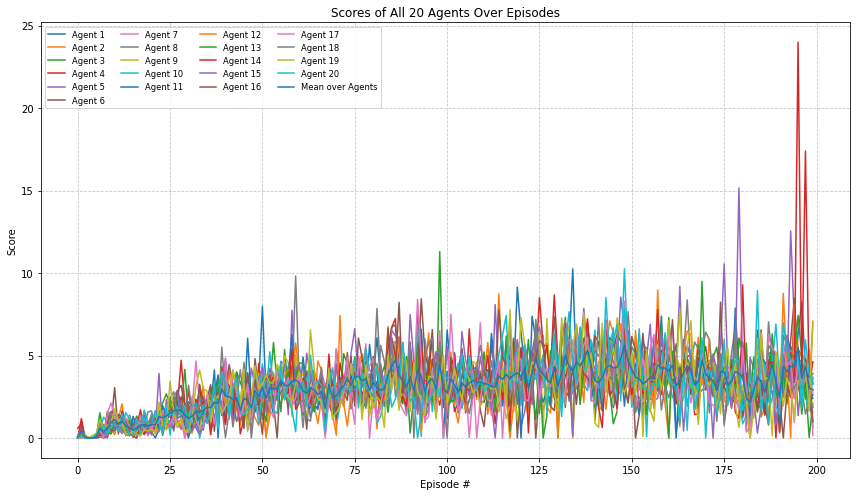

In [12]:
fig = plt.figure(figsize=(12, 7)) # Adjust figure size for better readability
ax = fig.add_subplot(111)

# Iterate through each agent's scores and plot them
# If using `transposed_np_array`, you can iterate directly over its rows:
# for i, score_list in enumerate(transposed_np_array):
for i, score_list in enumerate(all_scores):
    plt.plot(np.arange(len(score_list)), score_list, label=f'Agent {i+1}')

column_means_np = all_scores.mean(axis=0)

plt.plot(np.arange(len(column_means_np)), column_means_np, label=f'Mean over Agents')

# Add labels and title
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title("Scores of All 20 Agents Over Episodes")

# Add a legend to distinguish agents
# This is crucial when plotting multiple lines!
plt.legend(loc='best', ncol=4, fontsize='small') # Adjust legend position and columns as needed

# Add a grid for better readability of values
plt.grid(True, linestyle='--', alpha=0.7)

# Optimize layout to prevent labels/title from overlapping
plt.tight_layout()

# Display the plot
plt.show()

Successfully created directory: 'ddpg_trials\10'
Episode 100	Average Score: 0.02 [0.029099999349564313, 0.026899999398738147, 0.01769999960437417, 0.0270999993942678, 0.029799999333918095, 0.018799999579787254, 0.03469999922439456, 0.018099999595433472, 0.04329999903216958, 0.014299999680370093, 0.027699999380856752, 0.03269999926909804, 0.010899999756366014, 0.03749999916180968, 0.018999999575316905, 0.0305999993160367, 0.036999999172985555, 0.008099999818950892, 0.01989999955520034, 0.013699999693781138]]8]41]3]]]
Episode 200	Average Score: 0.04 [0.03729999916628003, 0.035699999202042816, 0.059299998674541714, 0.03229999927803874, 0.025999999418854714, 0.061099998634308574, 0.04069999909028411, 0.06589999852702022, 0.05699999872595072, 0.027199999392032624, 0.061699998620897534, 0.04139999907463789, 0.04999999888241291, 0.03349999925121665, 0.04869999891147017, 0.04089999908581376, 0.037899999152868985, 0.0456999989785254, 0.039199999123811724, 0.04429999900981784]]4]]6]


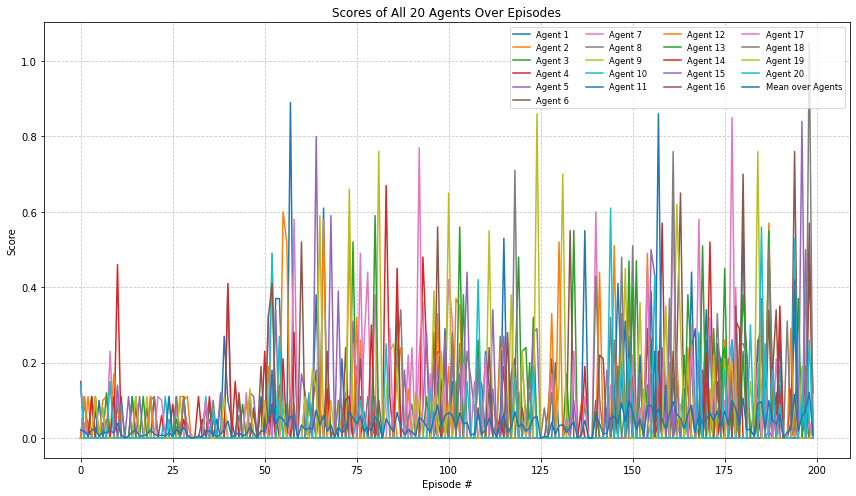

Successfully created directory: 'ddpg_trials\11'
Episode 100	Average Score: 4.57 [4.734999894164503, 4.0977999084070325, 4.680399895384908, 4.938199889622629, 4.65579989593476, 4.690799895152449, 4.661599895805121, 4.689499895181507, 4.51569989906624, 4.817499892320484, 4.4269999010488394, 4.507399899251759, 4.61309989688918, 4.313599903583526, 4.256499904859811, 4.470999900065363, 4.661599895805121, 4.9426998895220455, 4.407599901482463, 4.3158999035321175]]]6985]9]]4]]5]1]]55]]5]587]3]
Episode 200	Average Score: 13.14 [13.623399695493282, 13.419199700057506, 13.057299708146601, 13.20729970479384, 12.909899711441248, 13.316599702350794, 12.977499709930271, 12.87409971224144, 13.471999698877335, 13.511499697994442, 12.513199720308185, 13.060599708072841, 13.095099707301706, 13.447699699420482, 12.858799712583423, 12.993499709572642, 13.108799706995487, 12.98369970979169, 13.33599970191717, 12.938199710808695]42]]


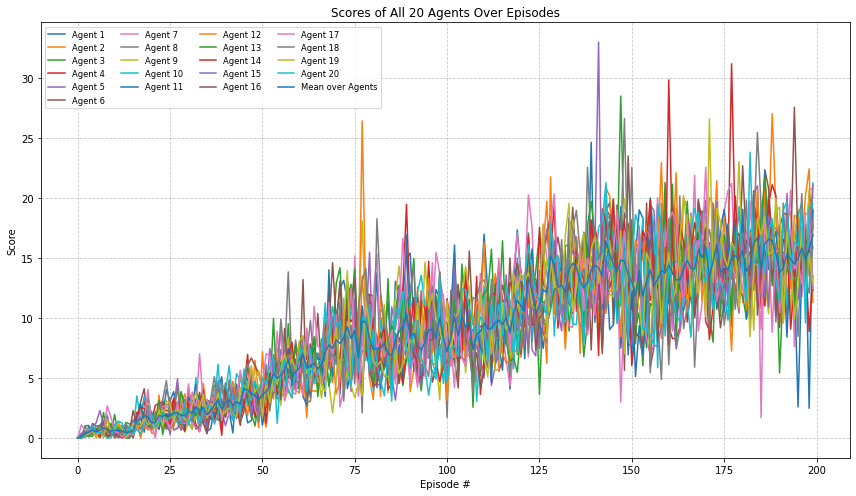

Successfully created directory: 'ddpg_trials\12'
Episode 100	Average Score: 0.66 [0.6496999854780734, 0.680899984780699, 0.70329998428002, 0.6427999856323003, 0.5138999885134399, 0.7699999827891588, 0.7662999828718603, 0.6523999854177237, 0.7322999836318195, 0.6580999852903188, 0.6196999861486256, 0.6311999858915806, 0.6735999849438667, 0.6304999859072268, 0.5676999873109162, 0.6369999857619405, 0.7195999839156866, 0.6416999856568872, 0.7196999839134515, 0.6129999862983823]82]34]]5]]4]3]38]]]]
Episode 200	Average Score: 1.71 [1.5697999649122358, 1.6628999628312886, 1.6250999636761845, 1.655199963003397, 1.827999959141016, 1.6859999623149633, 1.6451999632269143, 1.7863999600708484, 1.6498999631218612, 1.8466999587230384, 1.597699964288622, 1.7577999607101082, 1.7972999598272146, 1.7255999614298343, 1.6806999624334276, 1.813699959460646, 1.7126999617181717, 1.7116999617405235, 1.7558999607525765, 1.7001999619975685]]]]]


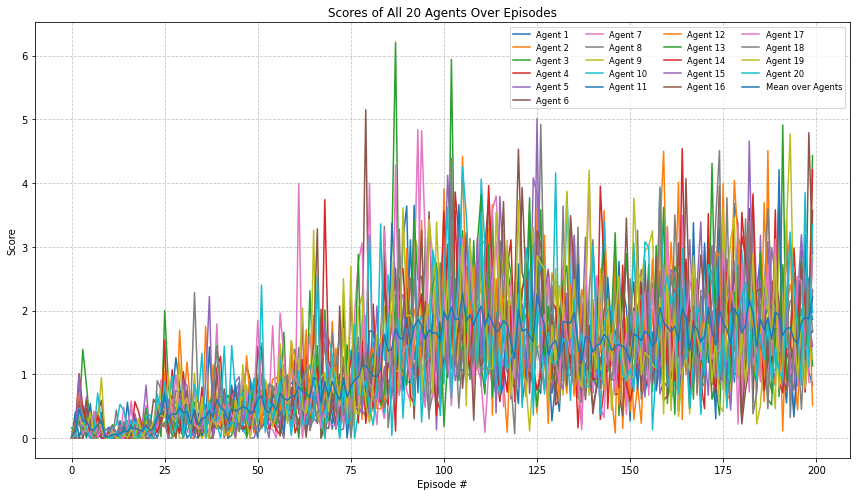

In [13]:
import os
import json
random_seed = 0

base_path = 'ddpg_trials'
combinations = [{
    #     "n_episodes": 200,
    #     "max_t": 1000, # Changed
    #     "BUFFER_SIZE": int(1e6), # Changed
    #     "BATCH_SIZE": 128,
    #     "GAMMA": 0.95, # Changed
    #     "TAU": 1e-2, # Changed
    #     "LR_ACTOR": 1e-5, # Changed
    #     "LR_CRITIC": 1e-5, # Changed
    #     "WEIGHT_DECAY": 0,
    #     "learn_every": 20,
    #     "learn_iterations": 10,
    # },
    # {
        "n_episodes": 200,
        "max_t": 1000, # Changed
        "BUFFER_SIZE": int(1e6), # Changed
        "BATCH_SIZE": 128,
        "GAMMA": 0.95, # Changed
        "TAU": 1e-2, # Changed
        "LR_ACTOR": 1e-4,
        "LR_CRITIC": 1e-4, # Changed
        "WEIGHT_DECAY": 0,
        "learn_every": 20,
        "learn_iterations": 10,
    },
    {
        "n_episodes": 200,
        "max_t": 1000,
        "BUFFER_SIZE": int(1e6), # Changed
        "BATCH_SIZE": 128,
        "GAMMA": 0.99,
        "TAU": 1e-3,
        "LR_ACTOR": 1e-4,
        "LR_CRITIC": 1e-3,
        "WEIGHT_DECAY": 0,
        "learn_every": 20,
        "learn_iterations": 10,
    },
    {
        "n_episodes": 200,
        "max_t": 1000,
        "BUFFER_SIZE": int(1e6), # Changed
        "BATCH_SIZE": 256, # Changed
        "GAMMA": 0.99,
        "TAU": 1e-3,
        "LR_ACTOR": 1e-4,
        "LR_CRITIC": 1e-4,
        "WEIGHT_DECAY": 0,
        "learn_every": 20,
        "learn_iterations": 10,
    },
    # {
    #     "n_episodes": 200,
    #     "max_t": 1000,
    #     "BUFFER_SIZE": int(1e4),
    #     "BATCH_SIZE": 128,
    #     "GAMMA": 0.99,
    #     "TAU": 1e-3,
    #     "LR_ACTOR": 1e-4,
    #     "LR_CRITIC": 1e-3,
    #     "WEIGHT_DECAY": 0,
    #     "learn_every": 20,
    #     "learn_iterations": 10,
    # },
 ]

for properties in combinations:
    new_path = create_next_id_folder(base_path)
    scores = ddpg(env, 
        state_size, 
        action_size, 
        random_seed,
        num_agents=num_agents,
        n_episodes=properties["n_episodes"],
        max_t=properties["max_t"],
        actor_model_save_path=os.path.join(new_path, 'actor.pth'),
        critic_model_save_path=os.path.join(new_path, 'critic.pth'),
        BUFFER_SIZE=properties["BUFFER_SIZE"],
        BATCH_SIZE=properties["BATCH_SIZE"],
        GAMMA=properties["GAMMA"],
        TAU=properties["TAU"],
        LR_ACTOR=properties["LR_ACTOR"],
        LR_CRITIC=properties["LR_CRITIC"],
        WEIGHT_DECAY=properties["WEIGHT_DECAY"],
        learn_every=properties["learn_every"],
        learn_iterations=properties["learn_iterations"],
        )
    
    with open(os.path.join(new_path, 'parameters.json'), 'w') as json_file:
        json.dump(properties, json_file,  indent=4)

    list_of_python_lists = []
    for arr in scores:
        list_of_python_lists.append(arr.tolist())

    with open(os.path.join(new_path, 'scores.json'), 'w') as f:
        json.dump(list_of_python_lists, f, indent=4) # indent makes it human-readable

    all_scores = np.array(list_of_python_lists)
    all_scores = all_scores.T

    fig = plt.figure(figsize=(12, 7)) # Adjust figure size for better readability
    ax = fig.add_subplot(111)

    # Iterate through each agent's scores and plot them
    # If using `transposed_np_array`, you can iterate directly over its rows:
    # for i, score_list in enumerate(transposed_np_array):
    for i, score_list in enumerate(all_scores):
        plt.plot(np.arange(len(score_list)), score_list, label=f'Agent {i+1}')

    column_means_np = all_scores.mean(axis=0)

    plt.plot(np.arange(len(column_means_np)), column_means_np, label=f'Mean over Agents')

    # Add labels and title
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title("Scores of All 20 Agents Over Episodes")

    # Add a legend to distinguish agents
    # This is crucial when plotting multiple lines!
    plt.legend(loc='best', ncol=4, fontsize='small') # Adjust legend position and columns as needed

    # Add a grid for better readability of values
    plt.grid(True, linestyle='--', alpha=0.7)

    # Optimize layout to prevent labels/title from overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()

Successfully created directory: 'ddpg_trials\13'
Episode 100	Average Score: 3.83 [3.8945999129489066, 3.5874999198131263, 3.585999919846654, 3.7356999165005984, 3.6527999183535576, 3.5172999213822185, 3.979399911053479, 3.987399910874665, 3.980999911017716, 4.177599906623364, 3.615299919191748, 3.4018999239616097, 3.5758999200724064, 4.190099906343967, 3.9191999123990535, 3.851899913903326, 3.7044999171979724, 4.200599906109273, 3.69739991735667, 4.248999905027449]]32]3]]]82]46]519]3]
Episode 200	Average Score: 11.88 [11.926999733410776, 12.246299726273865, 12.24579972628504, 12.190099727530033, 12.041199730858207, 11.407699745018036, 11.629099740069359, 11.559499741625041, 12.006199731640518, 11.784999736584723, 11.644799739718437, 11.601199740692973, 11.378699745666236, 12.287199725359677, 11.32969974676147, 12.482999720983207, 12.358499723765998, 11.480599743388593, 11.839899735357612, 12.147299728486686]]


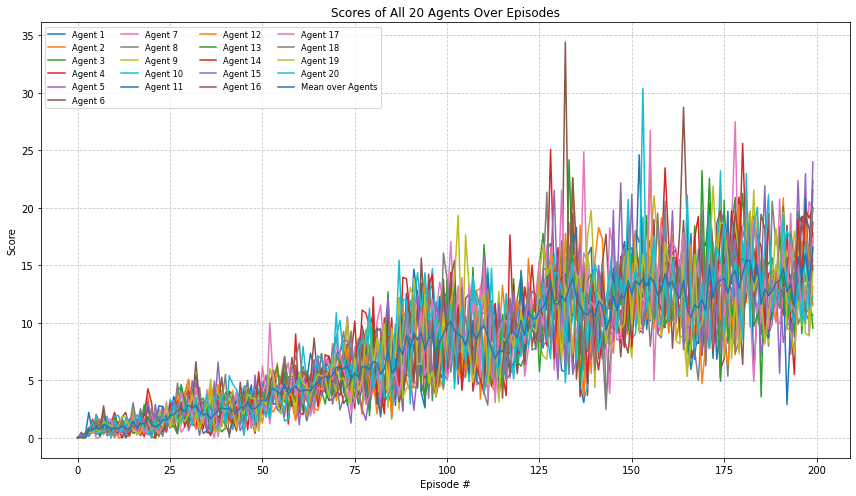

Successfully created directory: 'ddpg_trials\14'
Episode 100	Average Score: 0.42 [0.4814999892376363, 0.43169999035075307, 0.3912999912537634, 0.4380999902077019, 0.38479999139904975, 0.41419999074190855, 0.39519999116659166, 0.39169999124482274, 0.41389999074861406, 0.4456999900378287, 0.3994999910704792, 0.37319999165832995, 0.4201999906077981, 0.46069998970255255, 0.385799991376698, 0.4398999901674688, 0.48319998919963836, 0.42229999056085943, 0.33519999250769617, 0.41839999064803124]]37]]]]9]441]
Episode 200	Average Score: 2.30 [2.121999952569604, 2.2708999492414295, 2.2852999489195645, 2.4167999459803102, 2.2745999491587283, 2.203499950747937, 2.481399944536388, 2.3348999478109183, 2.462299944963306, 2.2805999490246176, 2.44559994533658, 2.2451999498158695, 2.42569994578138, 2.194399950951338, 2.375799946896732, 2.093099953215569, 2.1974999508820474, 2.5407999432086945, 2.061499953921884, 2.324699948038906]6]]784]]]]6]]1975]13746]


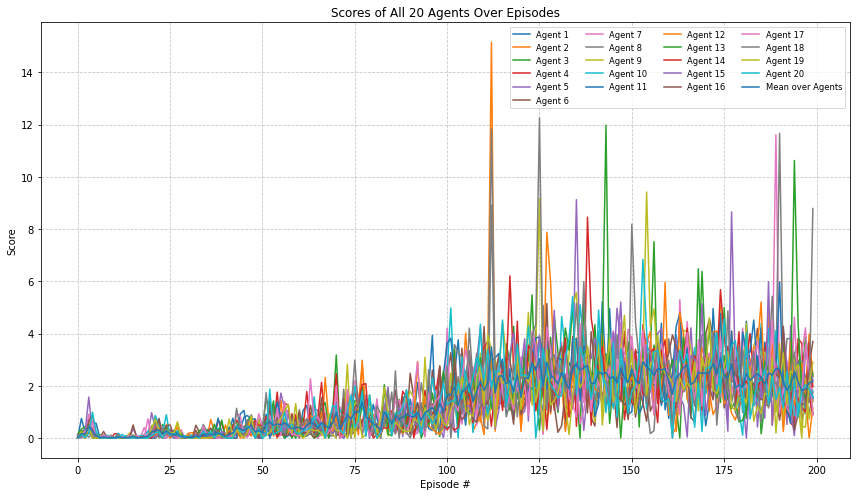

Successfully created directory: 'ddpg_trials\15'
Episode 100	Average Score: 3.13 [2.8910999353788793, 3.194799928590655, 3.073699931297451, 2.99969993295148, 2.8919999353587627, 3.3839999243617056, 3.3755999245494603, 3.1136999304033814, 2.985999933257699, 3.0759999312460424, 3.283399926610291, 3.0739999312907456, 3.0562999316863717, 3.1615999293327333, 3.1534999295137824, 2.933699934426695, 3.189799928702414, 3.1012999306805433, 3.2199999280273914, 3.3478999251686035]]]44]]144]729]
Episode 200	Average Score: 7.13 [6.885199846103787, 7.0801998417451975, 7.023199843019247, 7.109599841088056, 7.381799835003912, 6.994699843656272, 6.727499849628657, 7.281999837234617, 7.535899831559509, 6.773199848607183, 7.38879983484745, 7.165599839836359, 6.904999845661223, 7.074499841872603, 6.962099844384938, 6.970999844186008, 7.196599839143455, 7.328999836184084, 7.610799829885363, 7.266999837569893]088]]91]821]17]]
Episode 300	Average Score: 7.34 [8.050799820050598, 7.571499830763787, 7.7843998260

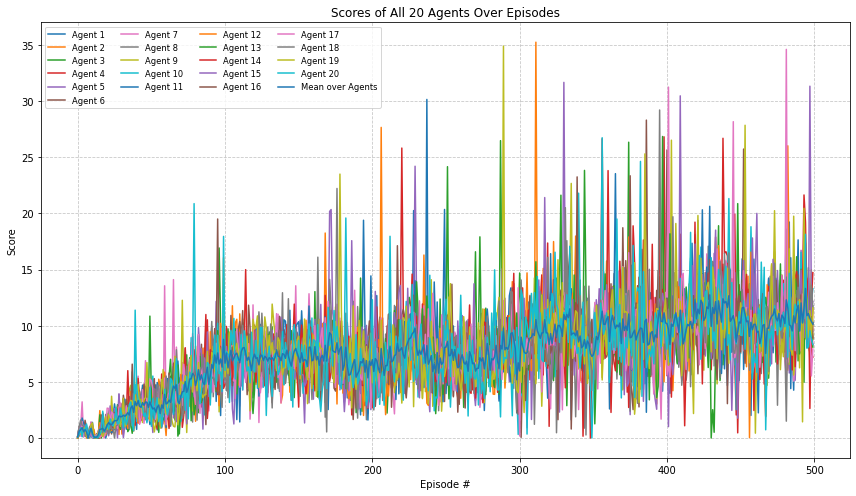

In [16]:
import os
import json
random_seed = 0

base_path = 'ddpg_trials'
combinations = [{
    #     "n_episodes": 200,
    #     "max_t": 1000,
    #     "BUFFER_SIZE": int(1e6), # Changed
    #     "BATCH_SIZE": 128,
    #     "GAMMA": 0.99,
    #     "TAU": 1e-3,
    #     "LR_ACTOR": 5e-4, # Changed
    #     "LR_CRITIC": 5e-3, # Changed
    #     "WEIGHT_DECAY": 0,
    #     "learn_every": 20,
    #     "learn_iterations": 10,
    # },
    # {
        "n_episodes": 200,
        "max_t": 1000,
        "BUFFER_SIZE": int(1e6), # Changed
        "BATCH_SIZE": 128,
        "GAMMA": 0.98, # Changed
        "TAU": 1e-3,
        "LR_ACTOR": 1e-4,
        "LR_CRITIC": 1e-3,
        "WEIGHT_DECAY": 0,
        "learn_every": 20,
        "learn_iterations": 10,
    },
    {
        "n_episodes": 200,
        "max_t": 1000,
        "BUFFER_SIZE": int(1e8), # Changed
        "BATCH_SIZE": 128,
        "GAMMA": 0.99,
        "TAU": 1e-3,
        "LR_ACTOR": 1e-4,
        "LR_CRITIC": 1e-3,
        "WEIGHT_DECAY": 0,
        "learn_every": 20,
        "learn_iterations": 10,
    },
    {
        "n_episodes": 500, # Changed
        "max_t": 1000,
        "BUFFER_SIZE": int(1e6), # Changed
        "BATCH_SIZE": 128,
        "GAMMA": 0.99,
        "TAU": 1e-3,
        "LR_ACTOR": 1e-4,
        "LR_CRITIC": 1e-3,
        "WEIGHT_DECAY": 0,
        "learn_every": 20,
        "learn_iterations": 10,
    },
 ]

for properties in combinations:
    new_path = create_next_id_folder(base_path)
    scores = ddpg(env, 
        state_size, 
        action_size, 
        random_seed,
        num_agents=num_agents,
        n_episodes=properties["n_episodes"],
        max_t=properties["max_t"],
        actor_model_save_path=os.path.join(new_path, 'actor.pth'),
        critic_model_save_path=os.path.join(new_path, 'critic.pth'),
        BUFFER_SIZE=properties["BUFFER_SIZE"],
        BATCH_SIZE=properties["BATCH_SIZE"],
        GAMMA=properties["GAMMA"],
        TAU=properties["TAU"],
        LR_ACTOR=properties["LR_ACTOR"],
        LR_CRITIC=properties["LR_CRITIC"],
        WEIGHT_DECAY=properties["WEIGHT_DECAY"],
        learn_every=properties["learn_every"],
        learn_iterations=properties["learn_iterations"],
        )
    
    with open(os.path.join(new_path, 'parameters.json'), 'w') as json_file:
        json.dump(properties, json_file,  indent=4)

    list_of_python_lists = []
    for arr in scores:
        list_of_python_lists.append(arr.tolist())

    with open(os.path.join(new_path, 'scores.json'), 'w') as f:
        json.dump(list_of_python_lists, f, indent=4) # indent makes it human-readable

    all_scores = np.array(list_of_python_lists)
    all_scores = all_scores.T

    fig = plt.figure(figsize=(12, 7)) # Adjust figure size for better readability
    ax = fig.add_subplot(111)

    # Iterate through each agent's scores and plot them
    # If using `transposed_np_array`, you can iterate directly over its rows:
    # for i, score_list in enumerate(transposed_np_array):
    for i, score_list in enumerate(all_scores):
        plt.plot(np.arange(len(score_list)), score_list, label=f'Agent {i+1}')

    column_means_np = all_scores.mean(axis=0)

    plt.plot(np.arange(len(column_means_np)), column_means_np, label=f'Mean over Agents')

    # Add labels and title
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title("Scores of All 20 Agents Over Episodes")

    # Add a legend to distinguish agents
    # This is crucial when plotting multiple lines!
    plt.legend(loc='best', ncol=4, fontsize='small') # Adjust legend position and columns as needed

    # Add a grid for better readability of values
    plt.grid(True, linestyle='--', alpha=0.7)

    # Optimize layout to prevent labels/title from overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()

In [ ]:
import os
import json
random_seed = 0

base_path = 'ddpg_trials'
combinations = [{
    #     "n_episodes": 200,
    #     "max_t": 1000,
    #     "BUFFER_SIZE": int(1e6), # Changed
    #     "BATCH_SIZE": 128,
    #     "GAMMA": 0.99,
    #     "TAU": 1e-3,
    #     "LR_ACTOR": 5e-4, # Changed
    #     "LR_CRITIC": 5e-3, # Changed
    #     "WEIGHT_DECAY": 0,
    #     "learn_every": 20,
    #     "learn_iterations": 10,
    # },
    # {
        "n_episodes": 200,
        "max_t": 1000,
        "BUFFER_SIZE": int(1e6), # Changed
        "BATCH_SIZE": 128,
        "GAMMA": 0.98, # Changed
        "TAU": 1e-3,
        "LR_ACTOR": 1e-4,
        "LR_CRITIC": 1e-3,
        "WEIGHT_DECAY": 0,
        "learn_every": 20,
        "learn_iterations": 10,
    },
    {
        "n_episodes": 200,
        "max_t": 1000,
        "BUFFER_SIZE": int(1e8), # Changed
        "BATCH_SIZE": 128,
        "GAMMA": 0.99,
        "TAU": 1e-3,
        "LR_ACTOR": 1e-4,
        "LR_CRITIC": 1e-3,
        "WEIGHT_DECAY": 0,
        "learn_every": 20,
        "learn_iterations": 10,
    },
    {
        "n_episodes": 500, # Changed
        "max_t": 1000,
        "BUFFER_SIZE": int(1e6), # Changed
        "BATCH_SIZE": 128,
        "GAMMA": 0.99,
        "TAU": 1e-3,
        "LR_ACTOR": 1e-4,
        "LR_CRITIC": 1e-3,
        "WEIGHT_DECAY": 0,
        "learn_every": 20,
        "learn_iterations": 10,
    },
 ]

for properties in combinations:
    new_path = create_next_id_folder(base_path)
    scores = ddpg(env, 
        state_size, 
        action_size, 
        random_seed,
        num_agents=num_agents,
        n_episodes=properties["n_episodes"],
        max_t=properties["max_t"],
        actor_model_save_path=os.path.join(new_path, 'actor.pth'),
        critic_model_save_path=os.path.join(new_path, 'critic.pth'),
        BUFFER_SIZE=properties["BUFFER_SIZE"],
        BATCH_SIZE=properties["BATCH_SIZE"],
        GAMMA=properties["GAMMA"],
        TAU=properties["TAU"],
        LR_ACTOR=properties["LR_ACTOR"],
        LR_CRITIC=properties["LR_CRITIC"],
        WEIGHT_DECAY=properties["WEIGHT_DECAY"],
        learn_every=properties["learn_every"],
        learn_iterations=properties["learn_iterations"],
        )
    
    with open(os.path.join(new_path, 'parameters.json'), 'w') as json_file:
        json.dump(properties, json_file,  indent=4)

    list_of_python_lists = []
    for arr in scores:
        list_of_python_lists.append(arr.tolist())

    with open(os.path.join(new_path, 'scores.json'), 'w') as f:
        json.dump(list_of_python_lists, f, indent=4) # indent makes it human-readable

    all_scores = np.array(list_of_python_lists)
    all_scores = all_scores.T

    fig = plt.figure(figsize=(12, 7)) # Adjust figure size for better readability
    ax = fig.add_subplot(111)

    # Iterate through each agent's scores and plot them
    # If using `transposed_np_array`, you can iterate directly over its rows:
    # for i, score_list in enumerate(transposed_np_array):
    for i, score_list in enumerate(all_scores):
        plt.plot(np.arange(len(score_list)), score_list, label=f'Agent {i+1}')

    column_means_np = all_scores.mean(axis=0)

    plt.plot(np.arange(len(column_means_np)), column_means_np, label=f'Mean over Agents')

    # Add labels and title
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title("Scores of All 20 Agents Over Episodes")

    # Add a legend to distinguish agents
    # This is crucial when plotting multiple lines!
    plt.legend(loc='best', ncol=4, fontsize='small') # Adjust legend position and columns as needed

    # Add a grid for better readability of values
    plt.grid(True, linestyle='--', alpha=0.7)

    # Optimize layout to prevent labels/title from overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()